In [1]:
#import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import torch
import torchvision
import torch.nn as nn
import torchmetrics
from torchvision import transforms

import torchvision.models as models
from torch.utils.data import DataLoader, Dataset,random_split
from pytorch_lightning import seed_everything, LightningModule, Trainer
from sklearn.metrics import classification_report


In [2]:
#测试GPU是否可用
import torch
torch.cuda.is_available()

True

In [3]:
# GPU
class OurModel(LightningModule):
    def __init__(self):
        super(OurModel,self).__init__()
        
        # model architecute  
        self.resnet18 = models.resnet18(pretrained=True)
        self.resnet18.fc=nn.Sequential(
            nn.Linear(self.resnet18.fc.in_features,224),
            nn.ReLU(),
            nn.Linear(224,1)
            )
        
        # augmentation
        self.aug=transforms.Compose([
                    transforms.Resize(size=(224,224)),
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomVerticalFlip(),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225]),
                    ])
        
        #parameters
        self.lr=1e-4
        self.batch_size=224
        self.numworker=1     ######################################## modify here #################################
        self.acc = torchmetrics.Accuracy(task='binary') # metric
        self.criterion=nn.BCEWithLogitsLoss() # loss function
        #list to store loss and accuracy
        self.trainacc,self.valacc=[],[]
        self.trainloss,self.valloss=[],[]
        
        ######################################## modify here #################################
        #load data        
        # self.dataset=torchvision.datasets.ImageFolder('Binary',transform=self.aug)
        dataroot = r'H:\0. videos\Bilibili\[医学AI-图像分类] COVID二分类问题-Pytorch源码\前处理\Binary'
        dataset=torchvision.datasets.ImageFolder(dataroot,transform=self.aug)
        
        #split data
        self.train_set, self.val_set =random_split(dataset,
                            [int(np.floor(len(dataset)*0.75)),int(np.ceil(len(dataset)*0.25))],
                                                  generator=torch.Generator().manual_seed(42))
    def forward(self,x):
        x=self.resnet18(x)
        return x

    
    def configure_optimizers(self):
        opt=torch.optim.AdamW(params=self.parameters(),lr=self.lr )
        return opt
    
    def train_dataloader(self):#load train 
        return DataLoader(self.train_set,shuffle=True,num_workers=self.numworker,batch_size=self.batch_size)

    def training_step(self,batch,batch_idx):
        image,label=batch
        pred = self(image)#pass images to model
        loss=self.criterion(pred.flatten(),label.float()) #calculate loss
        acc=self.acc(pred.flatten(),label)#calculate accuracy
        return {'loss':loss,'acc':acc}

    def training_epoch_end(self, outputs):
        #average loss and accuracy in all batches of train data
        loss=torch.stack([x["loss"] for x in outputs]).mean().detach().cpu().numpy().round(2)
        acc=torch.stack([x["acc"] for x in outputs]).mean().detach().cpu().numpy().round(2)
        self.trainacc.append(acc)
        self.trainloss.append(loss)

        
    def val_dataloader(self):
        ds=DataLoader(self.val_set,shuffle=False,num_workers=self.numworker,batch_size=self.batch_size)
        return ds

    def validation_step(self,batch,batch_idx):
        image,label=batch
        pred=self(image)
        loss=self.criterion(pred.flatten(),label.float())
        acc=self.acc(pred.flatten(),label)
        return {'loss':loss,'acc':acc}

    def validation_epoch_end(self, outputs):
        loss=torch.stack([x["loss"] for x in outputs]).mean().detach().cpu().numpy().round(2)
        acc=torch.stack([x["acc"] for x in outputs]).mean().detach().cpu().numpy().round(2)
        self.valacc.append(acc)
        self.valloss.append(loss)
        print('validation loss accuracy ',self.current_epoch,loss, acc)


In [4]:
model = OurModel()

C:\Users\ziyif\miniconda3\envs\pytorch_env1\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\ziyif\miniconda3\envs\pytorch_env1\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
# GPU
seed_everything(0) # Global seed set to 0 提高可复现性
trainer = Trainer(max_epochs=15, 
                deterministic=True,
                gpus=-1,precision=16,                                ###### modify here ###########
                accumulate_grad_batches=1,
                enable_progress_bar = True,
                num_sanity_val_steps=0,
                #limit_train_batches=20,
                #limit_val_batches=5
                )

Global seed set to 0
C:\Users\ziyif\miniconda3\envs\pytorch_env1\lib\site-packages\pytorch_lightning\trainer\connectors\accelerator_connector.py:441: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
  rank_zero_deprecation(
Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


为了保证实验的「可复现性」，许多机器学习的代码都会有一个方法叫 seed everything，这个方法尝试固定随机种子以让一些随机的过程在每一次的运行中产生相同的结果。

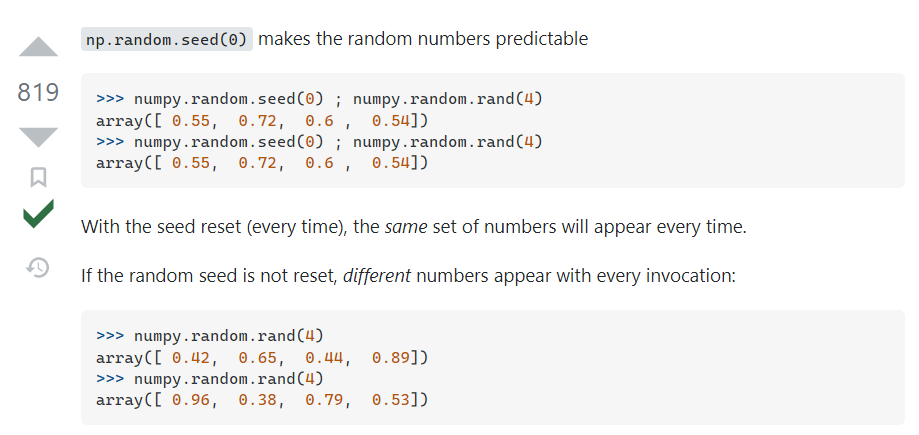

## Seed Everything - 可复现的 PyTorch（一）

https://zhuanlan.zhihu.com/p/577506804

In [6]:
trainer.fit(model)

Missing logger folder: H:\0. videos\Bilibili\[医学AI-图像分类] COVID二分类问题-Pytorch源码\训练-CPU GPU速度对比\lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params
------------------------------------------------
0 | resnet18  | ResNet            | 11.3 M
1 | acc       | BinaryAccuracy    | 0     
2 | criterion | BCEWithLogitsLoss | 0     
------------------------------------------------
11.3 M    Trainable params
0         Non-trainable params
11.3 M    Total params
22.583    Total estimated model params size (MB)
C:\Users\ziyif\miniconda3\envs\pytorch_env1\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\ziyif\miniconda3\envs\pytorc

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

validation loss accuracy  0 0.62 0.68


Validation: 0it [00:00, ?it/s]

validation loss accuracy  1 0.54 0.75


Validation: 0it [00:00, ?it/s]

validation loss accuracy  2 0.47 0.8


Validation: 0it [00:00, ?it/s]

validation loss accuracy  3 0.43 0.8


Validation: 0it [00:00, ?it/s]

validation loss accuracy  4 0.38 0.83


Validation: 0it [00:00, ?it/s]

validation loss accuracy  5 0.36 0.83


Validation: 0it [00:00, ?it/s]

validation loss accuracy  6 0.32 0.86


Validation: 0it [00:00, ?it/s]

validation loss accuracy  7 0.33 0.88


Validation: 0it [00:00, ?it/s]

validation loss accuracy  8 0.34 0.86


Validation: 0it [00:00, ?it/s]

validation loss accuracy  9 0.34 0.86


Validation: 0it [00:00, ?it/s]

validation loss accuracy  10 0.38 0.85


C:\Users\ziyif\miniconda3\envs\pytorch_env1\lib\site-packages\pytorch_lightning\trainer\call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [7]:
trainer.validate(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

validation loss accuracy  10 0.44 0.81


[{}]

Text(0.5, 1.0, 'validation and training accuracy comparison')

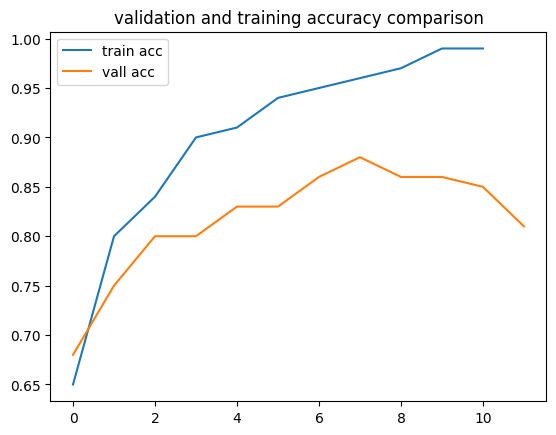

In [8]:
plt.plot(model.trainacc,label='train acc')
plt.plot(model.valacc,label='vall acc')
plt.legend()
plt.title('validation and training accuracy comparison')

Text(0.5, 1.0, 'validation and training loss comparison')

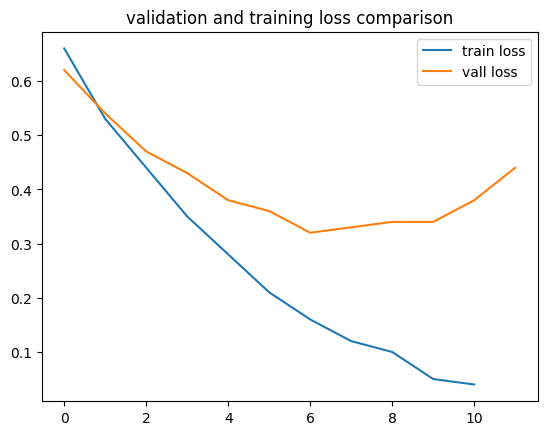

In [10]:
plt.plot(model.trainloss,label='train loss')
plt.plot(model.valloss,label='vall loss')
plt.legend()
plt.title('validation and training loss comparison')